In [2161]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.simplefilter("ignore", FutureWarning)
from sklearn import model_selection, preprocessing
from sklearn.model_selection import cross_val_score, train_test_split, KFold    
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, make_scorer, r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import skew
from sklearn.feature_selection import f_regression


df_train = pd.read_csv("/Users/cuongnguyen/Master/Data Science/Introduction to Data Science/Mini project/dataset/house-prices-advanced-regression-techniques/train.csv")
df_train.shape

(1460, 81)

In [2162]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [2163]:
df_train.shape

(1460, 81)

In [2164]:
df_train.drop(['Id'], axis=1, inplace=True)

In [2165]:
df_train = df_train[df_train.GrLivArea < 4000]
df_train.reset_index(drop=True, inplace=True)
# y = df_train['SalePrice'].reset_index(drop=True)

<b> We now would like to see the distribution of the target variable

/var/folders/s5/_19scpmn5qx24kgxtpzykrz00000gn/T/ipykernel_79113/886804650.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train['SalePrice'])


<AxesSubplot: xlabel='SalePrice', ylabel='Density'>

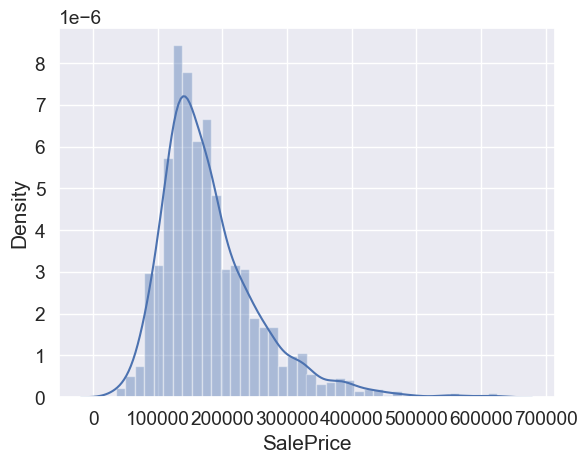

In [2166]:
sns.distplot(df_train['SalePrice'])

<b> It seems that 'SalePrice' deviates from the normal distribution, and have a positive skewness also shows peakedness

In [2167]:
df_train.SalePrice = np.log1p(df_train.SalePrice)
y = df_train.SalePrice

In [2168]:
disc_num_var = ['OverallQual','OverallCond','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
                'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'MoSold', 'YrSold']
numeric_ = df_train.select_dtypes(exclude = ["object"]).columns
numeric_ = df_train[numeric_]
cont_num_var = []
for i in numeric_.columns:
    if i not in disc_num_var:
        cont_num_var.append(i)

/var/folders/s5/_19scpmn5qx24kgxtpzykrz00000gn/T/ipykernel_79113/300786857.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(numeric_.loc[:,col].dropna(), kde=False)


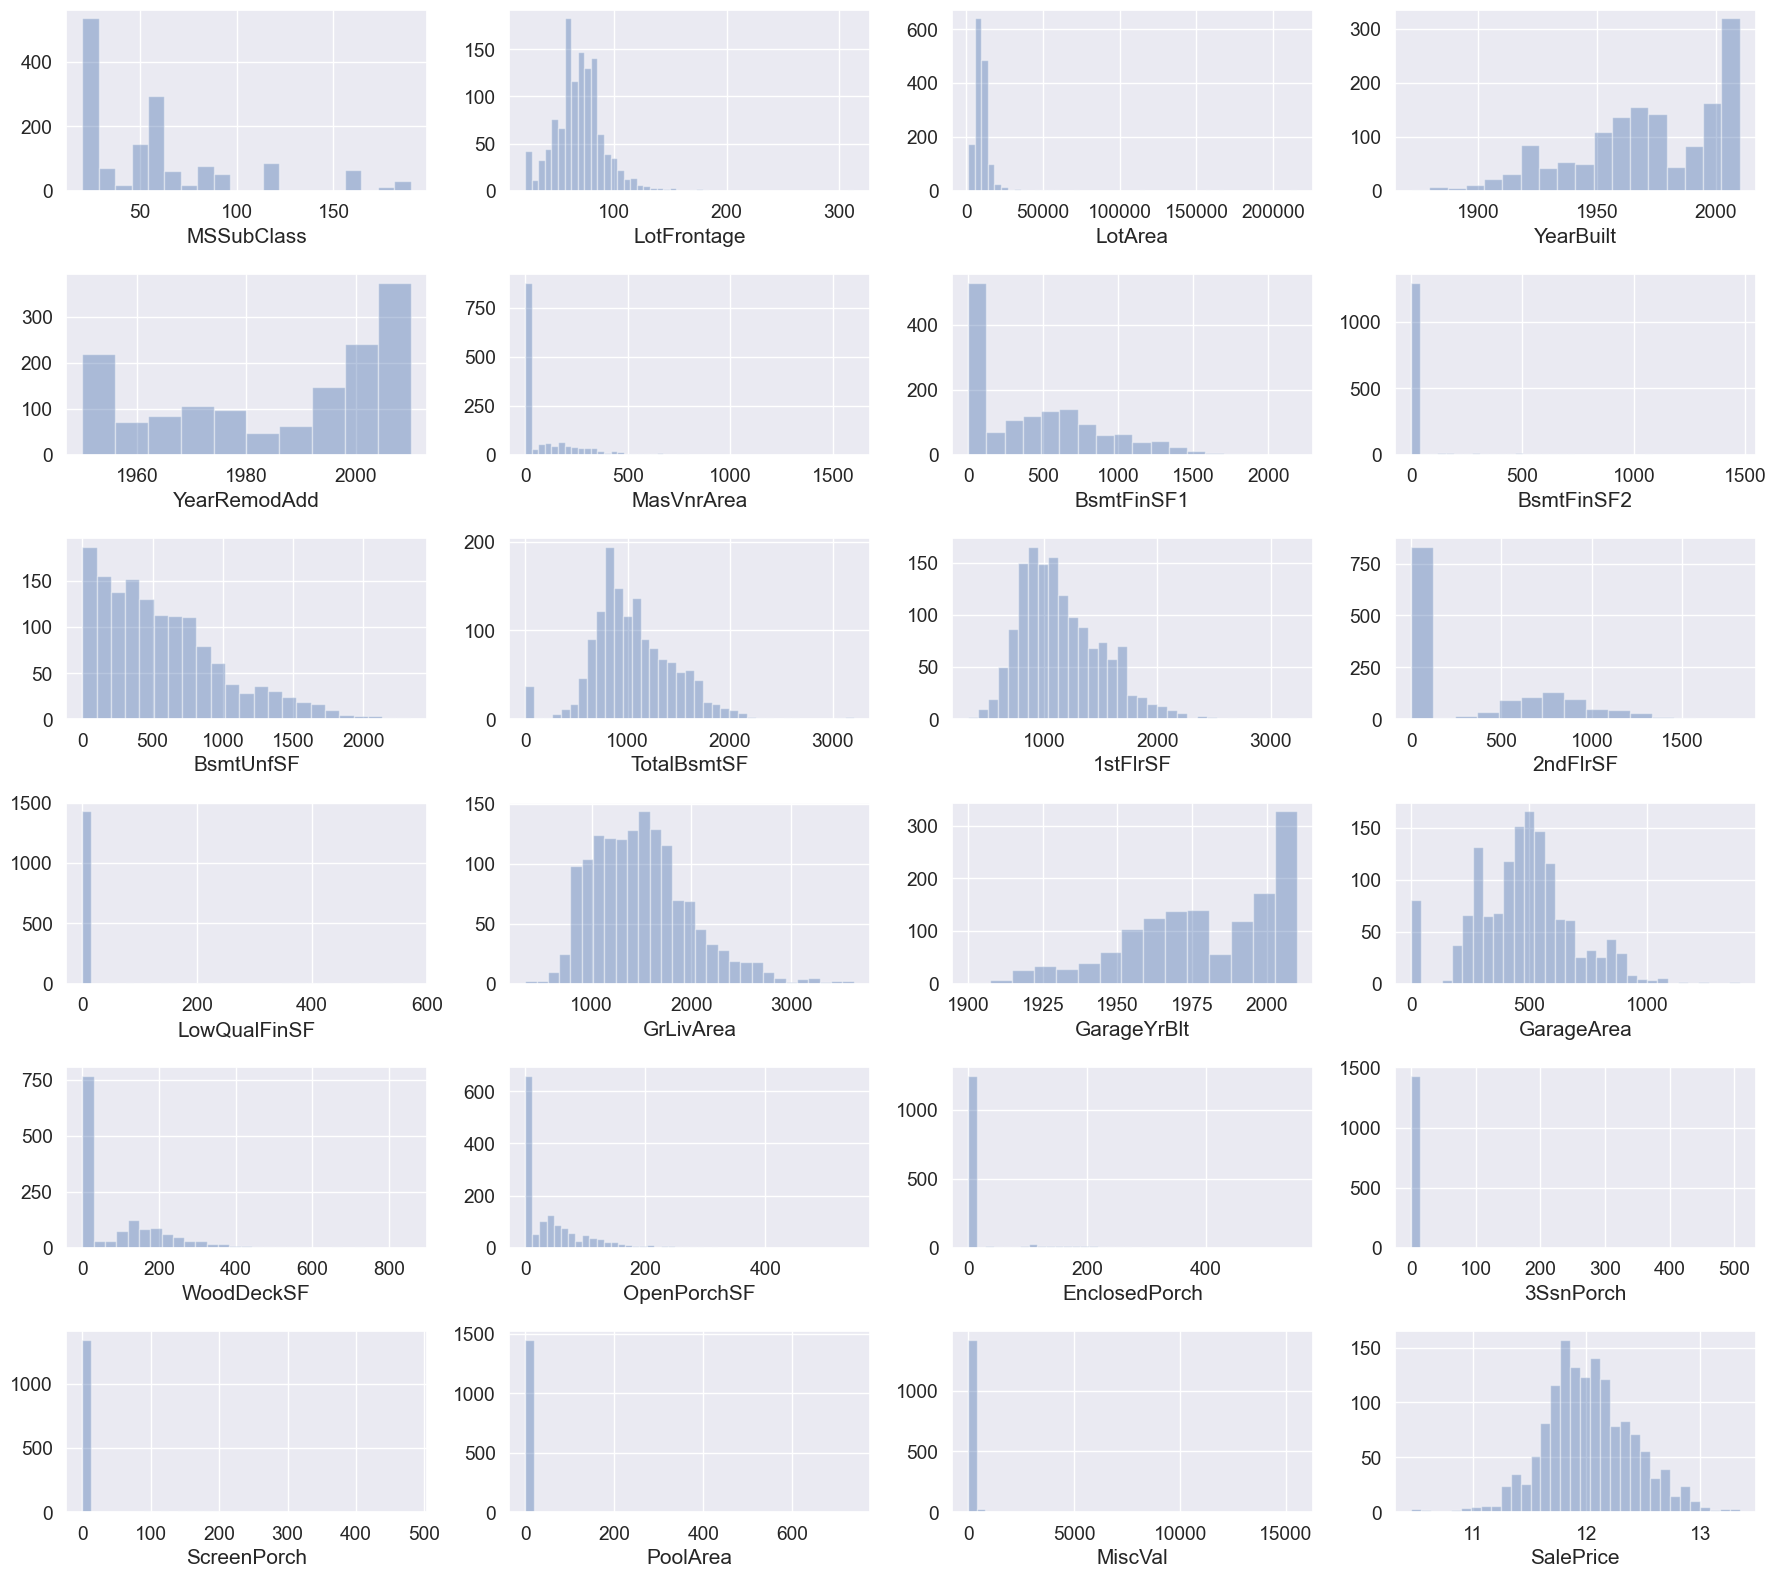

In [2169]:
fig = plt.figure(figsize=(18,16))
for index,col in enumerate(cont_num_var):
    plt.subplot(6,4,index+1)
    sns.distplot(numeric_.loc[:,col].dropna(), kde=False)
fig.tight_layout(pad=1.0)

<b> It seems there are presences of skewness in many feature distribution 

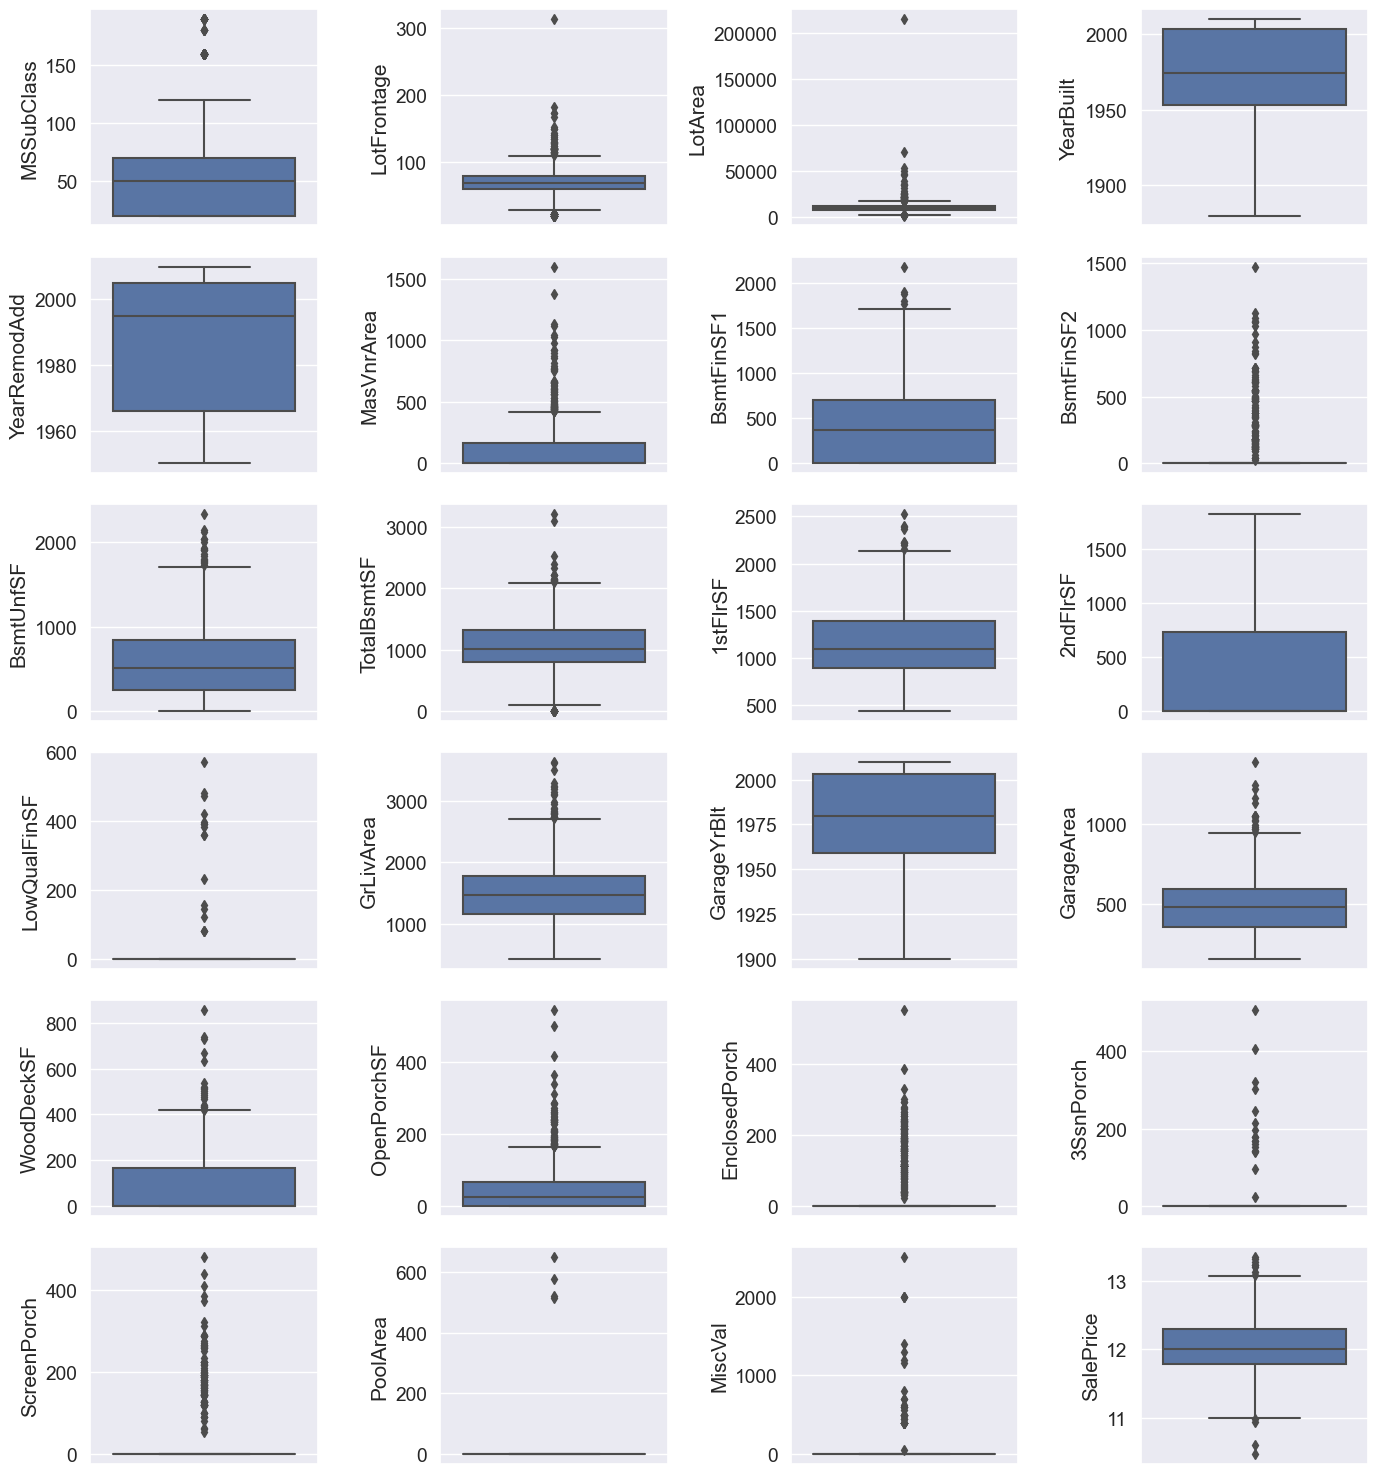

In [2170]:
fig = plt.figure(figsize=(14,15))
for index,col in enumerate(cont_num_var):
    plt.subplot(6,4,index+1)
    sns.boxplot(y=col, data=numeric_.dropna())
fig.tight_layout(pad=1.0)

Based the boxplot above we remove outliers 

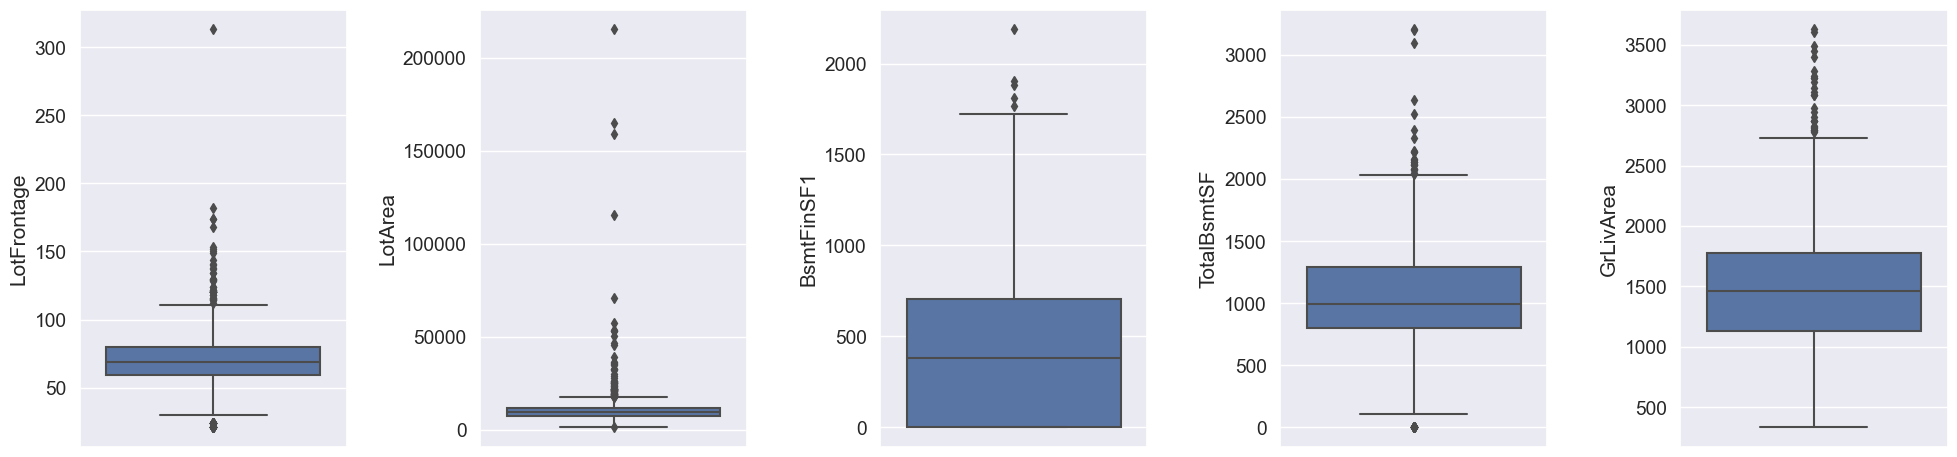

In [2171]:
out_col = ['LotFrontage','LotArea','BsmtFinSF1','TotalBsmtSF','GrLivArea']
fig = plt.figure(figsize=(20,5))
for index,col in enumerate(out_col):
    plt.subplot(1,5,index+1)
    sns.boxplot(y=col, data=df_train)
fig.tight_layout(pad=1.5)

In [2172]:
df_train = df_train.drop(df_train[df_train['LotFrontage'] > 200].index)
df_train = df_train.drop(df_train[df_train['LotArea'] > 100000].index)
df_train = df_train.drop(df_train[df_train['BsmtFinSF1'] > 4000].index)
df_train = df_train.drop(df_train[df_train['TotalBsmtSF'] > 5000].index)
df_train = df_train.drop(df_train[df_train['GrLivArea'] > 4000].index)

In [2173]:
#missing data
total_miss_num = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_miss_num, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1446,0.996554
MiscFeature,1399,0.964163
Alley,1360,0.937285
Fence,1171,0.807030
FireplaceQu,690,0.475534
LotFrontage,256,0.176430
GarageYrBlt,81,0.055824
GarageCond,81,0.055824
GarageType,81,0.055824
GarageFinish,81,0.055824


In [2174]:
useless_fea = ['GarageYrBlt','YearRemodAdd']
df_train = df_train.drop(useless_fea, axis = 1)

In [2175]:
#fill NaN numeric values with 0
df_train.loc[:, ["LotFrontage","MasVnrArea"]] = df_train.loc[:, ["LotFrontage","MasVnrArea"]].fillna(0)
#fill Nan categorical values 
df_train.loc[:, ["PoolQC","MiscFeature","Fence","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2"]] = df_train.loc[:, ["PoolQC","MiscFeature","Fence","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2"]].fillna("No")
df_train.loc[:, ["Alley","MasVnrType"]] = df_train.loc[:, ["Alley","MasVnrType"]].fillna("None")
df_train.loc[:, ["Electrical"]] = df_train.loc[:, ["Electrical"]].fillna("SBrkr")
df_train.loc[:, ["GarageQual","GarageCond","GarageFinish","GarageType","FireplaceQu"]] = df_train.loc[:, ["GarageQual","GarageCond","GarageFinish","GarageType","FireplaceQu"]].fillna("NA")

<b>Features transform

In [2176]:
df_train['MSSubClass'] = df_train['MSSubClass'].apply(str)
df_train['YrSold'] = df_train['YrSold'].apply(str)
df_train['MoSold'] = df_train['MoSold'].apply(str)

In [2177]:
# correlation
corr = df_train.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

SalePrice        1.000000
OverallQual      0.820971
GrLivArea        0.718065
GarageCars       0.681365
GarageArea       0.656334
TotalBsmtSF      0.640488
1stFlrSF         0.611166
YearBuilt        0.592079
FullBath         0.589899
TotRmsAbvGrd     0.534228
Fireplaces       0.483084
MasVnrArea       0.426632
BsmtFinSF1       0.379290
LotArea          0.359062
WoodDeckSF       0.332175
OpenPorchSF      0.329504
HalfBath         0.316010
2ndFlrSF         0.309899
BsmtFullBath     0.234225
BsmtUnfSF        0.226991
BedroomAbvGr     0.203779
LotFrontage      0.174612
ScreenPorch      0.125526
3SsnPorch        0.056786
PoolArea         0.041081
BsmtFinSF2       0.000052
BsmtHalfBath    -0.017774
MiscVal         -0.021121
LowQualFinSF    -0.037276
OverallCond     -0.037935
KitchenAbvGr    -0.147432
EnclosedPorch   -0.147526
Name: SalePrice, dtype: float64


<AxesSubplot: >

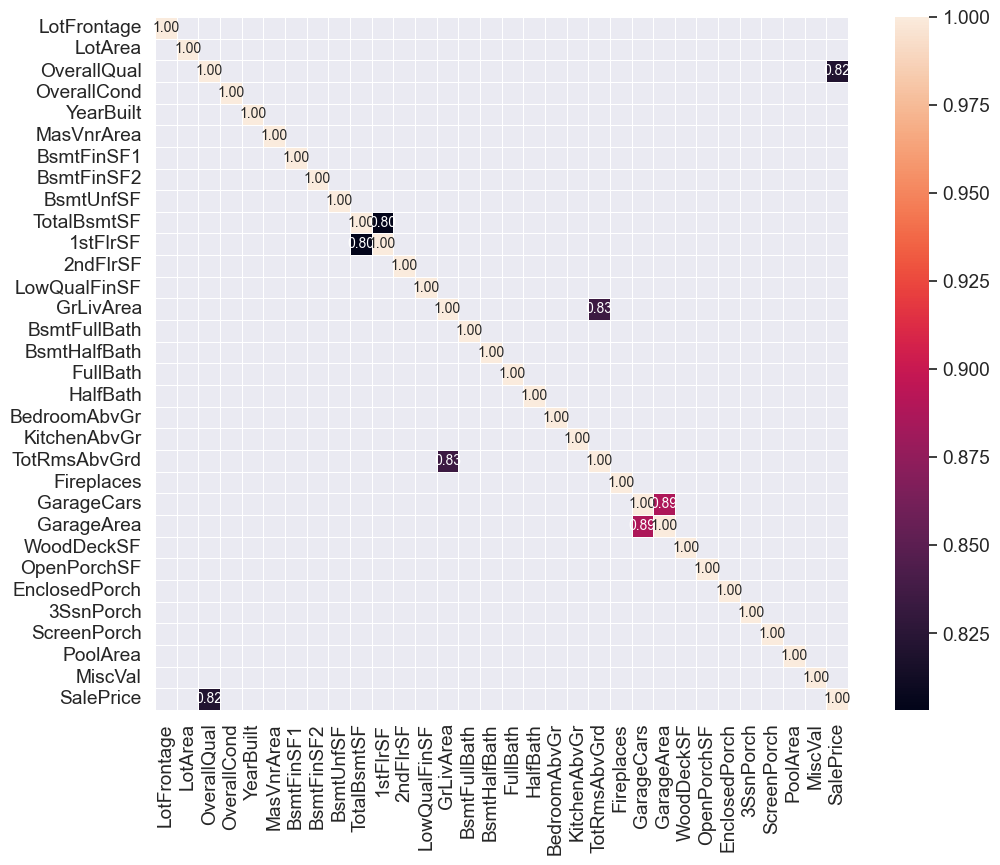

In [2178]:
#correlation matrix
corrmat = df_train.corr()
plt.figure(figsize=(12, 9))
sns.set(font_scale=1.25)
sns.heatmap(corrmat, mask = corrmat <0.8, linewidth=0.5, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})

<b>Drop features have high percentage of missing data and meaningless features

In [2179]:
df_train.drop(['PoolQC','MiscFeature','Alley','Fence'], axis=1, inplace=True)
df_train.drop(['MoSold','YrSold'], axis=1, inplace=True)

In [2180]:
y=df_train['SalePrice']
df_train = df_train.drop(['SalePrice'],axis=1)

In [2181]:
numerical_features = df_train.select_dtypes(exclude = ["object"]).columns
categorical_features = df_train.select_dtypes(include = ["object"]).columns
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
train_num = df_train[numerical_features]
train_cat = df_train[categorical_features]

Numerical features : 31
Categorical features : 40


In [2182]:
train_num.shape

(1451, 31)

In [2183]:
# Handle remaining missing values for numerical features by using median as replacement
print("NAs for numerical features in train : " + str(train_num.isnull().values.sum()))
train_num = train_num.fillna(train_num.median())
print("Remaining NAs for numerical features in train : " + str(train_num.isnull().values.sum()))

NAs for numerical features in train : 0
Remaining NAs for numerical features in train : 0


<b> Detect skewness in features then apply log transform 

In [2184]:
skewness = train_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
train_num[skewed_features] = np.log1p(train_num[skewed_features])

24 skewed numerical features to log transform


<b> Create dummy feature for categorical values via OHE

In [2185]:
print("NAs for categorical features in train : " + str(train_cat.isnull().values.sum()))
train_cat = pd.get_dummies(train_cat)
train_cat.shape
print("Remaining NAs for categorical features in train : " + str(train_cat.isnull().values.sum()))

NAs for categorical features in train : 0
Remaining NAs for categorical features in train : 0


In [2186]:
train_num.shape

(1451, 31)

In [2187]:
train = pd.concat([train_cat,train_num],axis=1)
train.shape

(1451, 293)

In [2188]:
y.shape

(1451,)

In [2189]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
selector = SelectKBest(score_func=f_regression, k=10)
train_new = selector.fit(train, y)
feature = []
scores = []
for i in range(len(selector.scores_)):
    feature.append(train.columns[i])
    scores.append(selector.scores_[i])
df = pd.DataFrame({'features': feature, 'score': scores})
print(df)

           features      score
0    MSSubClass_120  13.687475
1    MSSubClass_160  19.341402
2    MSSubClass_180  17.501766
3    MSSubClass_190  17.950222
4     MSSubClass_20   4.691769
..              ...        ...
288   EnclosedPorch  64.287543
289       3SsnPorch   5.391636
290     ScreenPorch  17.812026
291        PoolArea   2.437750
292         MiscVal   8.166274

[293 rows x 2 columns]


In [2190]:
# Sort the data frame by f-value and p-value
df = df.sort_values(by=['score'], ascending=False)
df = df.iloc[:10]
print(df)

           features        score
264     OverallQual  2995.697470
275       GrLivArea  1672.605708
284      GarageCars  1255.662261
285      GarageArea  1096.565294
271     TotalBsmtSF  1007.867977
272        1stFlrSF   852.112062
146    ExterQual_TA   818.739882
278        FullBath   773.329095
266       YearBuilt   773.232762
207  KitchenQual_TA   599.691996


In [2191]:
final_df = train[df.features]

<b> Modeling

In [2192]:
# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(final_df,y, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (1015, 10)
X_test : (436, 10)
y_train : (1015,)
y_test : (436,)


<b>Evaluation function

In [2193]:
models = pd.DataFrame(columns=["Model","MAE","MSE","RMSE","R2 Score","RMSE (Cross-Validation)"])

In [2194]:
# Creation of the RMSE metric:
    
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, train, y, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

def mae_scr(y, predictions):
    mae = mean_absolute_error(y, predictions)
    return mae
def r_sqr(y, predictions):
    r_squared = r2_score(y, predictions)
    return r_squared

In [2195]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)
cv_scores = []
cv_std = []
mae_lst = []
r2sqr = []

baseline_models = ['Linear_Reg.','Dec_Tree_Reg.','Random_Forest_Reg.']

In [2196]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
score_lreg = cv_rmse(lr)
predictions = lr.predict(X_test)
mae = mae_scr(y_test,predictions)
r2_sqr = r_sqr(y_test,predictions)
cv_scores.append(score_lreg.mean())
cv_std.append(score_lreg.std())
mae_lst.append(mae)
r2sqr.append(r2_sqr)

In [2197]:
# #Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)
score_rf = cv_rmse(rf)
predictions = rf.predict(X_test)
mae = mae_scr(y_test,predictions)
r2_sqr = r_sqr(y_test,predictions)
cv_scores.append(score_rf.mean())
cv_std.append(score_rf.std())
mae_lst.append(mae)
r2sqr.append(r2_sqr)

In [2198]:
#Decision Tree Regressor
dt = DecisionTreeRegressor(random_state=0)
dt.fit(X_train, y_train)
score_dt = cv_rmse(dt)
predictions = dt.predict(X_test)
mae = mae_scr(y_test,predictions)
r2_sqr = r_sqr(y_test,predictions)
cv_scores.append(score_dt.mean())
cv_std.append(score_dt.std())
mae_lst.append(mae)
r2sqr.append(r2_sqr)

In [2199]:
final_score = pd.DataFrame(baseline_models, columns = ['Regressors'])
final_score['RMSE_mean'] = cv_scores
final_score['RMSE_std'] = cv_std
final_score['MAE'] =  mae_lst
final_score['R2 Score'] = r2sqr

In [2200]:
final_score

,Regressors,RMSE_mean,RMSE_std,MAE,R2 Score
0,Linear_Reg.,0.121621,0.009553,0.109310,0.868355
1,Dec_Tree_Reg.,0.136878,0.010368,0.109571,0.863557
2,Random_Forest_Reg.,0.197745,0.013086,0.153311,0.697274


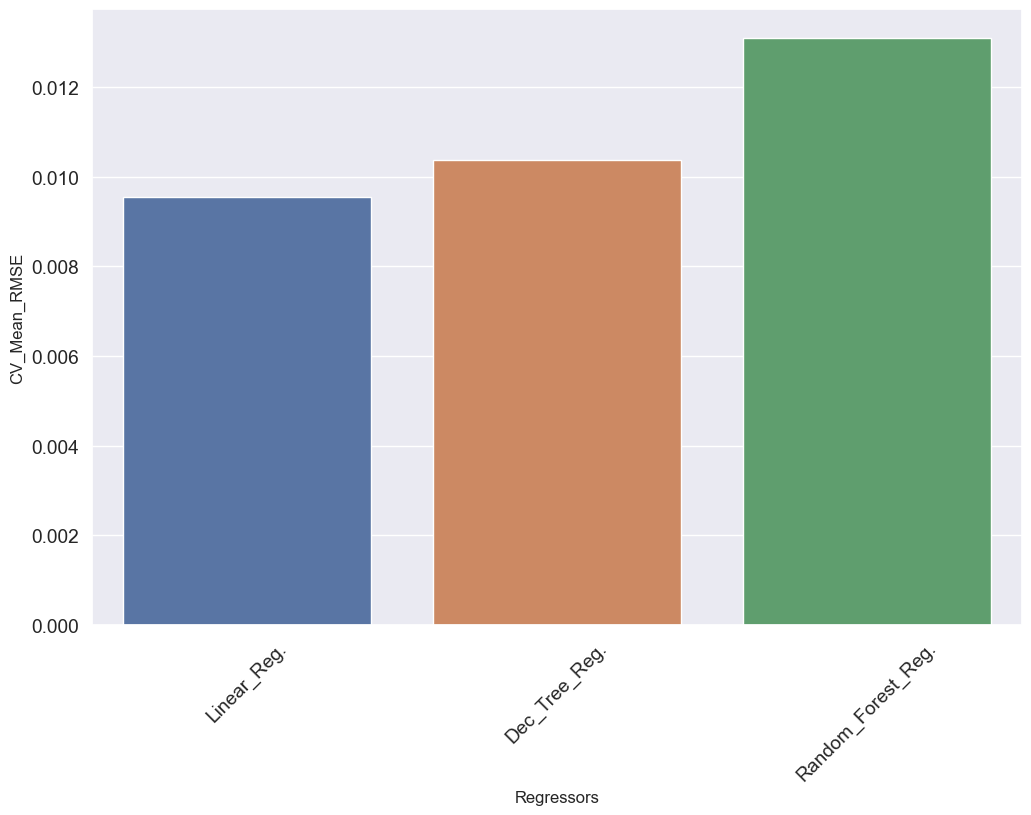

In [2201]:
plt.figure(figsize = (12,8))
sns.barplot(data=final_score,x='Regressors',y='RMSE_std')
plt.xlabel('Regressors', fontsize = 12)
plt.ylabel('CV_Mean_RMSE', fontsize = 12)
plt.xticks(rotation=45)
plt.show()